___

# More Advanced Clustering Demo

In this demo, we will step through different algorithms and see performance on different 2D data sets.

Some code was manipulated from 
- http://nbviewer.ipython.org/github/mgrani/LODA-lecture-notes-on-data-analysis/blob/master/2.ML-and-DM/2.ML-and-DM-Clustering-with-scikit-learn.ipynb 
- and also taken from sciki-learn's online documentation and example tutorials, http://scikit-learn.org/stable/index.html.

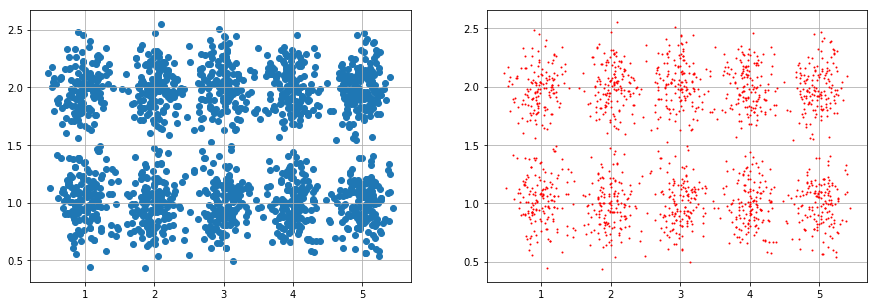

In [1]:
# getting things started
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np

# generate some sample data
n_samples = 1500
np.random.seed(0)

X1 = np.array([[1.0,1], [1,2], [2,1], [2,2], [3,1], [3,2], [4,1], [4,2], [5,1], [5,2]]) # cluster prototypes
X1 = np.repeat(X1, 150, axis=0)
X1 += .2 * np.random.randn(X1.shape[0],2) # add some randomness

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(X1[:, 0], X1[:, 1])
plt.grid()
plt.subplot(1,2,2)
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.grid()

plt.show()

This data should be relatively easy to cluster. The density of each cluster is constant and it has ten distinct clusters. There is some overlap, but by and large, the overall clusters are visually obvious.

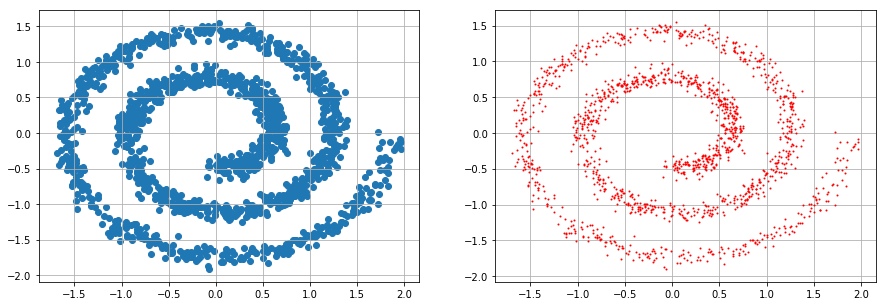

In [2]:
# Generate some harder sample data
t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
x = t * np.cos(t) / 10.0
y = t * np.sin(t) / 10.0

X2 = np.concatenate((x, y))
X2 += .07 * np.random.randn(2, n_samples) # add some randomness
X2 = X2.T # and transpose it

# and then lets plot it
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(X2[:, 0], X2[:, 1])
plt.grid()
plt.subplot(1,2,2)
plt.plot(X2[:, 0], X2[:, 1], 'r.', markersize=2) #plot the data
plt.grid()

plt.show()

This data set is more difficult to cluster as it has a differing shape constraint. However there is very little overlap between the clusters so it is quite distinct and visually obvious.

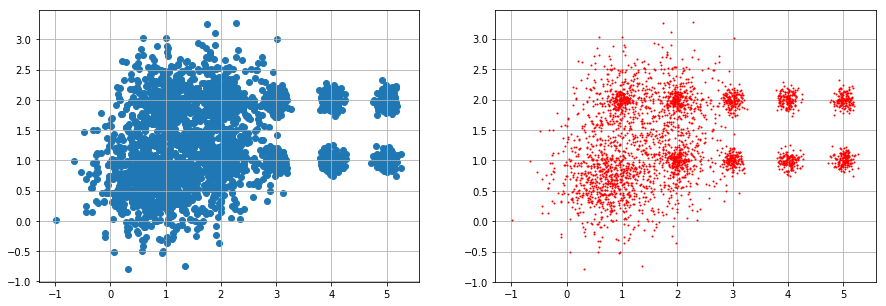

In [3]:
X3 = np.array([[0.75,0.75],[0.75,0.75], [1,2], [2,1], [2,2], [3,1], [3,2], [4,1], [4,2], [5,1], [5,2]]) # cluster prototypes
X3 = np.repeat(X3, 150, axis=0)
X3 += .1 * np.random.randn(X3.shape[0],2) # add some randomness
X3[0:300] += .3 * np.random.randn(300,2)

Xtmp1 = X3[0:750] + .4 * np.random.randn(750,2) # create some spread in the points
Xtmp2 = X3[0:750] + .4 * np.random.randn(750,2) # create some spread in the points
X3 = np.concatenate((X3,Xtmp1,Xtmp2)) # and add them back in for differing density


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(X3[:, 0], X3[:, 1])
plt.grid()
plt.subplot(1,2,2)
plt.plot(X3[:, 0], X3[:, 1], 'r.', markersize=2) #plot the data
plt.grid()

plt.show()

Here also the clusters are visually obvious, but the density of each cluster is now different. Some clusters contain many points, while others contain a fraction of the number of points. Also, the first cluster has double the number of points than other clusters.

In [4]:
%%time
from sklearn.neighbors import kneighbors_graph

# create connectivity graphs before calcualting the hierarchy
X1_knn_graph = kneighbors_graph(X1, 5)
X2_knn_graph = kneighbors_graph(X2, 5) 
X3_knn_graph = kneighbors_graph(X3, 5)

CPU times: user 894 ms, sys: 139 ms, total: 1.03 s
Wall time: 1.57 s


___
# Gaussian Mixture Models

In [11]:
# this code has been manipulated from the source available on sklearn's website documentation
import itertools

import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import mixture

X = X3


lowest_bic = np.infty
bic = []
n_components_range = range(7, 17)
cv_types = ['spherical', 'diag', 'full']
for cv_type in cv_types:
    for n_components in n_components_range:
        # Fit a mixture of Gaussians with EM
        gmm = mixture.GaussianMixture(n_components=n_components, covariance_type=cv_type)
        gmm.fit(X)
        bic.append(gmm.bic(X))
        if bic[-1] < lowest_bic:
            lowest_bic = bic[-1]
            best_gmm = gmm


The Bayesian information criterion is explained in the documentation of sklearn as a comparison technique that penalizes fitted GMM models based upon the number of parameters in the models. The classical definition of the BIC is:

$BIC=\underbrace{-2\ln(l)}_{\text{better fit==more negative}}+\underbrace{k\ln(N)}_{\text{more complex==more positive}} $

where $l$ is the likelihood of the GMM model given the observations, $k$ is the number of clusters, and $N$ is the number of instances in the dataset. In sklearn, the value of $k$ is also determined by the number of parameters in the Gaussian mixtures (i.e., the number of parameters to estimate including the the covariance matrix). In this way, the second parameter penalizes more complex models by adding to the BIC. 

In code, sklearn uses:
`return (- 2 * self.score(X).sum() + self._n_parameters() * np.log(X.shape[0]))`

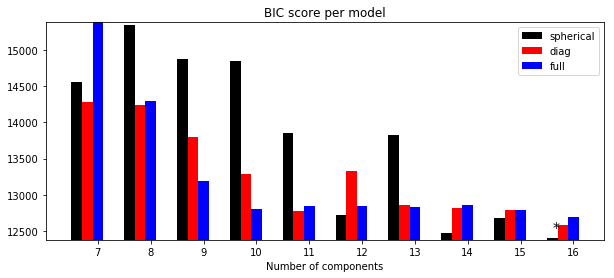

In [12]:
# this code has been manipulated from the source available on sklearn's website documentation
# plot the BIC
bic = np.array(bic)
color_iter = itertools.cycle(['k', 'r', 'b', 'g', 'c', 'm', 'y'])
clf = best_gmm
bars = []

plt.figure(figsize=(10,4))
spl = plt.subplot(1,1,1)
# Plot the BIC scores
for i, (cv_type, color) in enumerate(zip(cv_types, color_iter)):
    xpos = np.array(n_components_range) + .2 * (i - 2)
    bars.append(plt.bar(xpos, bic[i * len(n_components_range):
                                  (i + 1) * len(n_components_range)],
                        width=.2, color=color))
plt.xticks(n_components_range)
plt.ylim([bic.min() * 1.01 - .01 * bic.max(), bic.max()])
plt.title('BIC score per model')

xpos = np.min(n_components_range)-0.4 + np.mod(bic.argmin(), len(n_components_range)) +\
    .2 * np.floor(bic.argmin() / len(n_components_range))
plt.text(xpos, bic.min() * 0.97 + .03 * bic.max(), '*', fontsize=14)
spl.set_xlabel('Number of components')
spl.legend([b[0] for b in bars], cv_types)

plt.show()

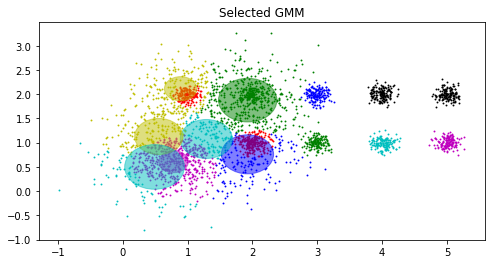

In [13]:
# this code has been manipulated from the source available on sklearn's website documentation
# Plot the winner
plt.figure(figsize=(8,4))
splot = plt.subplot(1,1,1)
Y_ = clf.predict(X)
for i, (mean, covar, color) in enumerate(zip(clf.means_, clf.covariances_,
                                             color_iter)):
    if len(covar.shape)<2:
        tmp = np.zeros((2,2))
        np.fill_diagonal(tmp,covar)
        covar = tmp
    elif covar.shape[0] != covar.shape[1]:
        covar = np.diag(covar)
        
    v, w = linalg.eigh(covar)
    if not np.any(Y_ == i):
        continue
    plt.scatter(X[Y_ == i, 0], X[Y_ == i, 1], .8, color=color)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan2(w[0][1], w[0][0])
    angle = 180 * angle / np.pi  # convert to degrees
    v *= 4
    ell = mpl.patches.Ellipse(mean, v[0], v[1], 180 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(.5)
    splot.add_artist(ell)


plt.title('Selected GMM')
plt.show()

___
# Spectral Clustering
Spectal clustering can be a powerful tool for clustering using many of the same methods we have already talked about in a different space. The sklearn documentation for the function is here:
- http://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html

Let's start by investigating how this performs with different affinity matrices.

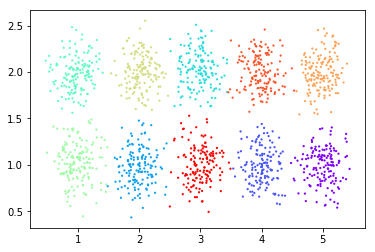

In [14]:
# an example using SpectralClustering, which assumes that the graphical data needs to be calculated from the structure
from sklearn.cluster import SpectralClustering

X = X1
nclust = 10

# If a string, this may be one of 
#  ‘nearest_neighbors’, ‘precomputed’, ‘rbf’ 
#  or one of the kernels supported by sklearn.metrics.pairwise_kernels
spc = SpectralClustering(n_clusters=nclust, affinity = 'nearest_neighbors')
labels = spc.fit_predict(X)

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

/Users/eclarson/anaconda/envs/MLEnv/lib/python3.5/site-packages/sklearn/utils/validation.py:640: UserWarning: Array is not symmetric, and will be converted to symmetric by average with its transpose.
  warnings.warn("Array is not symmetric, and will be converted "


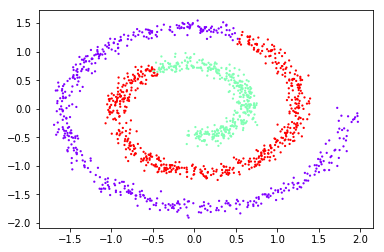

In [16]:
# an example using precomputed affinity, which uses the actual proximity graph
from sklearn.cluster import SpectralClustering
from sklearn.neighbors import kneighbors_graph

X = X2
nclust = 3
Xknn = kneighbors_graph(X, 10) 

spc = SpectralClustering(n_clusters=nclust, affinity = 'precomputed')
labels = spc.fit_predict(Xknn) 

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

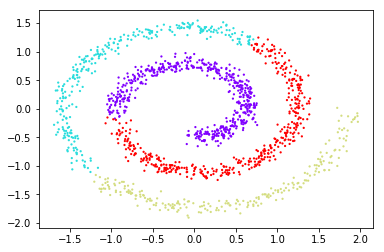

In [18]:
from sklearn.metrics.pairwise import pairwise_distances

X = X2
nclust = 4

d = pairwise_distances(X, metric='euclidean')
d = np.exp(- d**2 / (2.* 0.1**2)) # convert from euclidean distance to similarity
# this is Eric's function, empirically it works

spc = SpectralClustering(n_clusters=nclust, affinity = 'precomputed', eigen_solver = 'arpack')
labels = spc.fit_predict(d) 

plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=5, linewidths=0)

plt.show()

___
# Image Segmentation with Spectral Clustering
In this example we will construct an image and then cluster it by first converting the pixels into a graph. We will use a feature extraction method for images from sklearn called `img_to_graph`:
- http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.image.img_to_graph.html

In essence, this creates a graph where each pixel of the image is a node in the graph. If the pixels are adjacent to one another, then the edge between the pixels exists. The weight of the edge is given by the gradient of the image. In the example below, the gradient is mostly consistent across the patches in the graph, but the connectivity between pixels in the circles is very deterministic of the points. Let's see if Spectral Clustering can deal with these types of data clusterings.

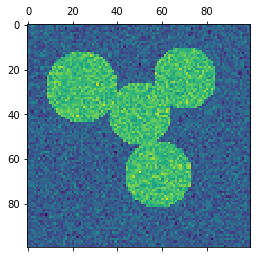

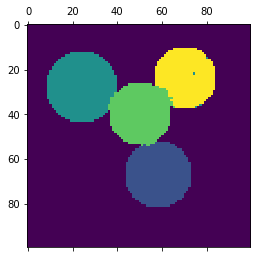

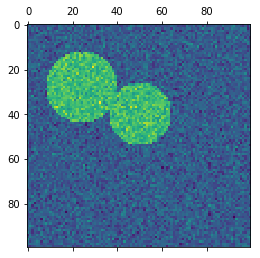

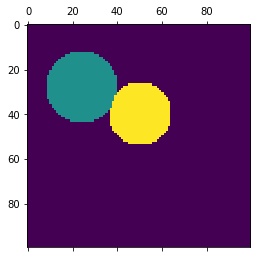

CPU times: user 2.84 s, sys: 138 ms, total: 2.97 s
Wall time: 3.33 s


In [43]:
%%time 
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction import image

###############################################################################
# create the image using default parameters
l = 100
x, y = np.indices((l, l))

center1 = (28, 24)
center2 = (40, 50)
center3 = (67, 58)
center4 = (24, 70)

radius1, radius2, radius3, radius4 = 16, 14, 15, 14

circle1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 < radius1 ** 2
circle2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 < radius2 ** 2
circle3 = (x - center3[0]) ** 2 + (y - center3[1]) ** 2 < radius3 ** 2
circle4 = (x - center4[0]) ** 2 + (y - center4[1]) ** 2 < radius4 ** 2

noise_power = 0.2

###############################################################################
# 4 circles
img = circle1 + circle2 + circle3 + circle4
mask = img.astype(bool) # create a mask (can also not use mask, np.ones(img.shape).astype(bool))
img = img.astype(float)

img += 1 + noise_power * np.random.randn(*img.shape) # add noise *==pass tuple as parameters separately

# Convert the image into a graph with the value of the gradient on the
# edges. This is only done on the unmasked part of the image. 
graph = image.img_to_graph(img, mask=mask) # and tell it where to get rid of the noise

# Force the solver to be arpack, since amg is numerically
# unstable on this example
spc = SpectralClustering(n_clusters=4, affinity = 'precomputed', eigen_solver='arpack')
labels = spc.fit_predict(graph) # predict from the setup object
label_im = -np.ones(mask.shape) # get the clustering label for each pixel inside the mask. 
label_im[mask] = labels # set the labels

plt.matshow(img)
plt.matshow(label_im)

###############################################################################
# 2 circles
img = circle1 + circle2
mask = img.astype(bool)
img = img.astype(float)

img += 1 + noise_power * np.random.randn(*img.shape)

graph = image.img_to_graph(img, mask=mask)

spc = SpectralClustering(n_clusters=2, affinity = 'precomputed', eigen_solver='arpack')
labels = spc.fit_predict(graph)
label_im = -np.ones(mask.shape)
label_im[mask] = labels

plt.matshow(img)
plt.matshow(label_im)

plt.show()

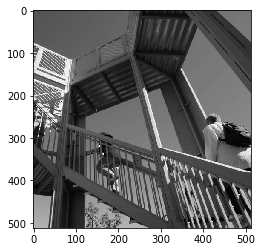

In [12]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

some_image = sp.misc.ascent() # get a 512x512 image!
plt.imshow(some_image,   cmap=plt.cm.gray)

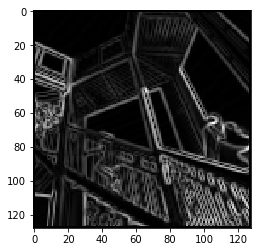

In [47]:
from skimage.filters import sobel_h, sobel_v
img = some_image.astype(np.float32)
img /= np.max(img)
gradient = np.sqrt(sobel_h(img)**2 + sobel_v(img)**2)
plt.imshow(gradient, cmap=plt.cm.gray)

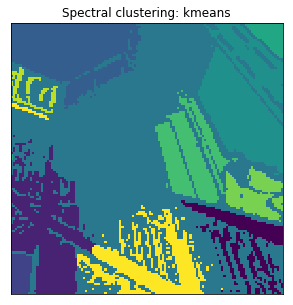

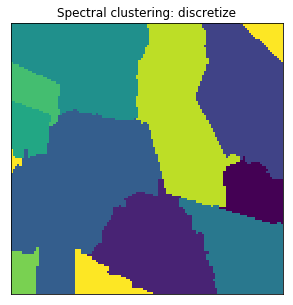

In [13]:
%%time
from sklearn.feature_extraction import image
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from sklearn.feature_extraction import image

%matplotlib inline

some_image = sp.misc.ascent() # get the lena image!
# Downsample the image by a factor of 4
some_image = some_image[::2, ::2] + some_image[1::2, ::2] + some_image[::2, 1::2] + some_image[1::2, 1::2]
some_image = some_image[::2, ::2] + some_image[1::2, ::2] + some_image[::2, 1::2] + some_image[1::2, 1::2]

# Convert the image into a graph with the value of the gradient on the
# edges.
graph = image.img_to_graph(some_image)

# Take a decreasing function of the gradient: an exponential
# The smaller beta is, the more independent the segmentation is of the
# actual image. For beta=1, the segmentation is close to a voronoi
beta = 5
eps = 1e-6
graph.data = np.exp(-beta * graph.data / some_image.std()) + eps
# similar to the distance mapping from above 

# Apply spectral clustering (this step goes much faster if you have pyamg
# installed)
N_REGIONS = 11

###############################################################################
# Visualize the resulting regions
for assign_labels in ('kmeans', 'discretize'):
    spc = SpectralClustering(n_clusters=N_REGIONS, 
                             affinity = 'precomputed', 
                             eigen_solver='arpack',
                             assign_labels=assign_labels)
    labels = spc.fit_predict(graph)
    labels = labels.reshape(some_image.shape)

    plt.figure(figsize=(5, 5))
    plt.imshow(some_image,   cmap=plt.cm.gray)
    plt.imshow(labels)
    
    plt.xticks(())
    plt.yticks(())
    plt.title('Spectral clustering: %s' % (assign_labels))

plt.show()

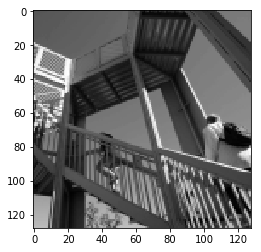

In [14]:
plt.imshow(some_image, cmap=plt.cm.gray)

___
# What if we have a lot of data?
Graphlab create to the rescue, but only for kmeans clustering using kmeans++. 
https://dato.com/products/create/docs/index.html

Graphlab Create only works on python 2.7, so at this point, I need to switch the kernel in the notebook to glenv. Then reload the data.

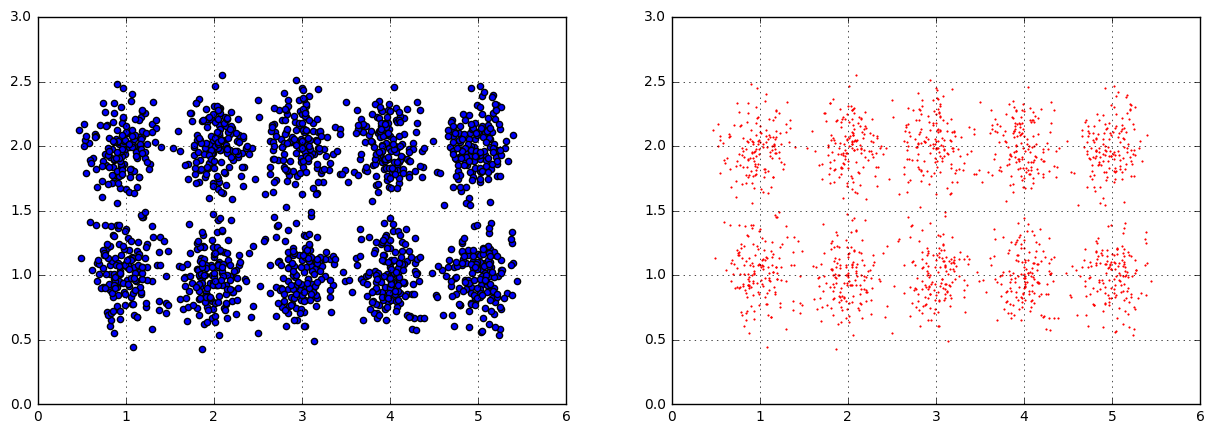

In [1]:
# getting things started
%matplotlib inline

import time
import matplotlib.pyplot as plt
import numpy as np

# generate some sample data
n_samples = 1500
np.random.seed(0)

X1 = np.array([[1.0,1], [1,2], [2,1], [2,2], [3,1], [3,2], [4,1], [4,2], [5,1], [5,2]]) # cluster prototypes
X1 = np.repeat(X1, 150, axis=0)
X1 += .2 * np.random.randn(X1.shape[0],2) # add some randomness

plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(X1[:, 0], X1[:, 1])
plt.grid()
plt.subplot(1,2,2)
plt.plot(X1[:, 0], X1[:, 1], 'r.', markersize=2) #plot the data
plt.grid()

plt.show()

In [2]:
# A tast of using graphlab with k-means clustering
# note that SFrames are powerful datatypes that are dynamic to the environment
# they also basically work like pandas and scikit-learn
import graphlab as gl
from IPython.display import display
from IPython.display import Image

gl.canvas.set_target('ipynb')

In [3]:
#  None: Use the default (depends on which Canvas target is set).
# ‘Table’: Show a scrollable, tabular view of the data in the SFrame.
# ‘Summary’: Show a list of columns with some summary statistics and plots for each column.
# ‘Scatter Plot’: Show a scatter plot of two numeric columns.
# ‘Heat Map’: Show a heat map of two numeric columns.
# ‘Bar Chart’: Show a bar chart of one numeric and one categorical column.
# ‘BoxWhisker Plot’: Show a box and whisker plot of one numeric and one categorical column.
# ‘Line Chart’: Show a line chart of one numeric and one categorical column.
import pandas as pd
XS = gl.SFrame(data=pd.DataFrame(X1))
print XS
XS.show(view="Summary")

This non-commercial license of GraphLab Create for academic use is assigned to eclarson@smu.edu and will expire on October 27, 2017.


[INFO] graphlab.cython.cy_server: GraphLab Create v2.1 started. Logging: /tmp/graphlab_server_1490841285.log


+----------------+----------------+
|       0        |       1        |
+----------------+----------------+
| 1.35281046919  | 1.08003144167  |
| 1.19574759682  | 1.44817863984  |
| 1.37351159803  | 0.804544424025 |
| 1.19001768351  | 0.96972855834  |
| 0.979356229641 | 1.08211970039  |
| 1.02880871423  | 1.29085470139  |
| 1.15220754503  |  1.0243350033  |
| 1.08877264655  | 1.06673486547  |
| 1.29881581463  | 0.958968347247 |
| 1.06261354033  | 0.82918085214  |
+----------------+----------------+
[1500 rows x 2 columns]
Note: Only the head of the SFrame is printed.
You can use print_rows(num_rows=m, num_columns=n) to print more rows and columns.


In [4]:
model = gl.kmeans.create(XS, num_clusters=10, max_iterations=50)
model.summary()

Batch size is larger than the input dataset. Switching to an exact Kmeans method.

Choosing initial cluster centers with Kmeans++.

+---------------+-----------+

| Center number | Row index |

+---------------+-----------+

| 0             | 35        |

| 1             | 1213      |

| 2             | 890       |

| 3             | 244       |

| 4             | 969       |

| 5             | 414       |

+---------------+-----------+

Starting kmeans model training.

Assigning points to initial cluster centers.

+-----------+-------------------------------+

| Iteration | Number of changed assignments |

+-----------+-------------------------------+

| 1         | 111                           |

| 2         | 32                            |

| 3         | 12                            |

| 4         | 4                             |

| 5         | 2                             |

| 6         | 1                             |

| 7         | 1                             |

| 8         | 1                             |

Class                            : KmeansModel

Schema
------
Number of clusters               : 10
Number of examples               : 1500
Number of feature columns        : 2
Number of unpacked features      : 2
Row label name                   : row_id

Training Summary
----------------
Training method                  : elkan
Number of training iterations    : 9
Batch size                       : 1500
Total training time (seconds)    : 1.1634

Accessible fields
-----------------
cluster_id                      : An SFrame containing the cluster assignments.
cluster_info                    : An SFrame containing the cluster centers.


| 9         | 0                             |

+-----------+-------------------------------+

In [7]:
labels_as_sframe = model.get('cluster_id')

labels_as_sframe.show()

[[ 1.35281047  1.08003144]
 [ 1.1957476   1.44817864]
 [ 1.3735116   0.80454442]
 ..., 
 [ 5.06400639  2.41583533]
 [ 4.8185068   1.96151916]
 [ 4.75749685  1.9838803 ]] [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ... ]


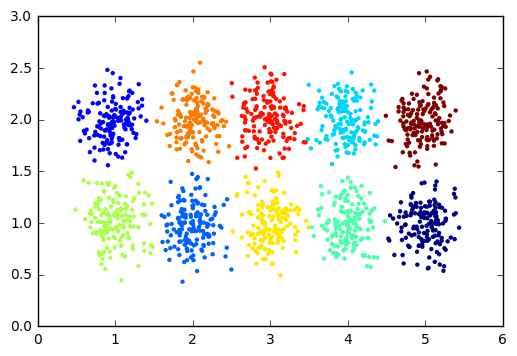

In [8]:
X = XS.to_dataframe().values
print X,labels_as_sframe['cluster_id']
plt.scatter(X[:,0], X[:,1], c=labels_as_sframe['cluster_id'],
                     s=10, linewidths=0)

plt.show()

In [9]:
model.show()